# 멤버십 리워드 효과 추정 
- DoWhy 를 사용하여 고객에 대한 구독 또는 리워드 프로그램의 의 효과를 추정해보자
- 고객이 웹사이트에 가입하면 혜택을 받는 리워드 프로그램이 존재하는데, 이때 이 해당 프로그램이 효과적인지 밝혀내는 분석입니다.

# Reference 
- dowhy 공식 홈페이지 Example

In [ ]:
import numpy as np
import pandas as pd
import os, sys
import dowhy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dowhy
# pygraphviz install 
!apt install libgraphviz-dev
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.4 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 4 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,

In [ ]:
# Creating some simulated data for our example example
num_users = 10000
num_months = 12

# signup month 는 유저가 리워드 프로그램에 가입한 월(month) 을 나타냅니다.
# 0 : Customer 가 리워드 프로그램에 Signup 하지 않았음을 의미합니다. 

signup_months = np.random.choice(np.arange(1, num_months), num_users)\
                * np.random.randint(0,2, size=num_users)  # 0,1 사이 정수. Unif
# 50% 의 유저는 리워드 프로그램에 signup 하지 않았고, 나머지 50% 의 유저의 경우 1~11월에 가입일이 균등(Unif) 하게 분포되어있다. 
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months), 
    'signup_month': np.repeat(signup_months, num_months), 
    'month': np.tile(np.arange(1, num_months+1), num_users), # months  는 1 ~ 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# user_id : 유저id
# month : 데이터의 수집 month
# signup_month : 유저가 리워드 프로그램에 가입한 월
# spend : 유저가 사용한 돈

# signup month 에 의거해서 Treatment 할당 여부 만들기 (0 이면 할당되었음을 의미)
df["treatment"] = (1-(df["signup_month"]==0)).astype(bool)

# month 에 대한 효과 Simulation (연말이 될수록 적게 사는 관계 Simulation)
df["spend"] = df["spend"] - df["month"]*10

# treatment effect 를 100으로 설정함
# Signup 을 하게되면 spend 가 다음달부터 100 증가하게 된다. 
after_signup = (df["signup_month"] < df["month"]) & (df["signup_month"] !=0)
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,465,False
1,0,0,2,473,False
2,0,0,3,424,False
3,0,0,4,457,False
4,0,0,5,438,False
...,...,...,...,...,...
119995,9999,0,8,430,False
119996,9999,0,9,423,False
119997,9999,0,10,447,False
119998,9999,0,11,398,False


# 문제 상황 
- 리워드 구독을 한 유저와 그렇지 않은 유저간의 Spend 차이 비교를 하고싶다.
- 하지만 단순 비교를 하게되면 이는 맞지 않다. 
    - 구독한 유저군과 그렇지 않은 유저군 간 Comparable 하지 않을 수 있기 떄문이다. 
- 또한 데이터가 User 별로 되어있지 않고, 시점별로 되어있기때문에 이를 어떻게 처리해야 할지도 문제 요소이다.

# 데이터 전처리 (feature 생성)
- i (기준 month)
    - 이런 실험데이터의 경우 늘 "시계열의 영향" 이 매우 크다. 즉 1\~3월의 평균과 3\~5평균은 아예 다르다고 보는게 맞다. 
    - 그러므로 우리가 보고자 하는 post_spend 와 pre_spend 는 모두 특정 time - window 에 대한 평균인데, 이 time-window 를 Control User 와 Treatment User 모두 맞추어줘야 동등한 비교가 된다는 이야기다. 
- post_spend (Target)
    - 우선 우리가 구하고 싶은것은 "Sign up 하고 난 이후의 spend 효과" 이다. 즉 각 유저에 대해서 sign up 이후, spend 평균을 계산하자.
    - 이때 Control 유저의 경우 sign up 이 없으므로 post_spend 는 전체 기간에 대한 평균 spend 가 된다. 
- pre_spend (Confounder)
    - sign-up 하기 전에 이 유저가 얼마나 돈을 사용하는지(spend)
    - 유저가 돈을 이미 많이 사용한다면, 분명 sign-up 에도 영향을 끼칠거라고 생각한다. 즉 Confounder 로 작용할 것이다.

In [ ]:
# 위 데이터로부터 얻을 수 있는 변수는 다음과 같다. 
# post_spend = sign up 이후에 얻은 평균 소득이라고 하자. 
# 우리는 아래의 인과를 얻고싶다.
# treatment(sign up 여부) -> post_spend
# 둘 사이의 Confounder 라고 할 만한 변수는 prespend

In [ ]:
# 정말 단순히 비교하게 되면 ATE 는 약 50임 
df.groupby("treatment").agg(np.mean)[["spend"]]

,spend
treatment,
False,435.003058
True,485.460036


# Propensity Matching for month 3
- Propensity Matching 을 사용하여서 비교해보자. 
    - Comparable 한 Group 을 만들기 위해서 Matching 을 시도한다. 
    - 추가적으로 Propensity Score 를 이용한 Marthincg 을 시도합니다. 

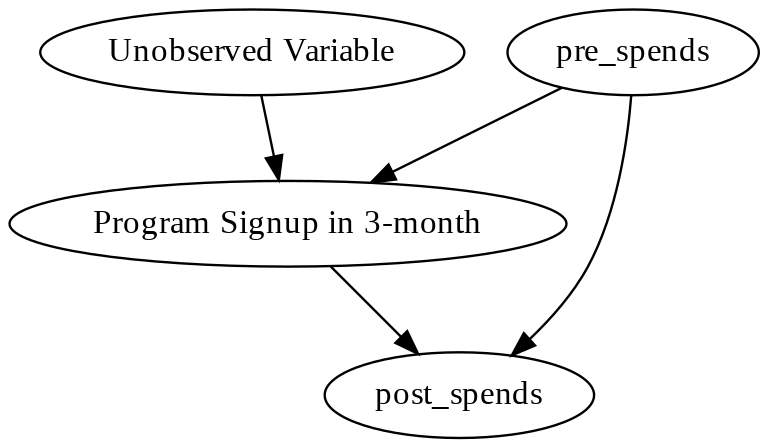

In [ ]:
# signup_month 는 시계열적 특성을 나타내므로 모델에 포함하는게 맞을것입니다. 
# 다만 우리의 경우 month 를 고정하고 분석하는것이므로 모델에서는 포함시키지 않겠습니다. 
# Setting the signup month (for ease of analysis)

i = 3
# signup_month = 0,3 인 유저에 대해서 prespend / postspend 를 정의
# 3개월을 기준으로 3개월 이전 spend 평균 / 3개월 이후 spend 평균 2가지를 정의 
df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
    lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                        'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
).reset_index()
df_i_signupmonth

causal_graph = """digraph {
treatment[label="Program Signup in 3-month"];
pre_spends;
post_spends;
Z[label = "Unobserved Variable"];
Z->treatment;
pre_spends -> post_spends;
pre_spends -> treatment;
treatment-> post_spends;
}"""
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                           
────────────(Expectation(post_spends|pre_spends))
d[treatment]                                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,pre_spends,U) = P(post_spends|treatment,pre_spends)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(post_spends, [Z])*Derivative([treatment], [Z])**(-1))
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{treatment}, then ¬({Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
### Estimand - backdoor 에 따르면 signup_month 만 통제(Condtioning) 하게 되면 Causal - Estimand 를 추정할 수 있을것입니다. 
# 위의 Backdoor 추정치를 활용하여서, 효과를 추정해봅시다. 
# 이때 사용한 방법은 Propensity Score Matching 을 사용했습니다. 
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                target_units="ate")
print(estimate)

propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                           
────────────(Expectation(post_spends|pre_spends))
d[treatment]                                     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,pre_spends,U) = P(post_spends|treatment,pre_spends)

## Realized estimand
b: post_spends~treatment+pre_spends
Target units: ate

## Estimate
Mean value: 99.88839914294462



# Propensity Matching
- 모든 월에 대한 분석을 다르게 생성하여서 그 영향을 최대한 줄이려고 하였음


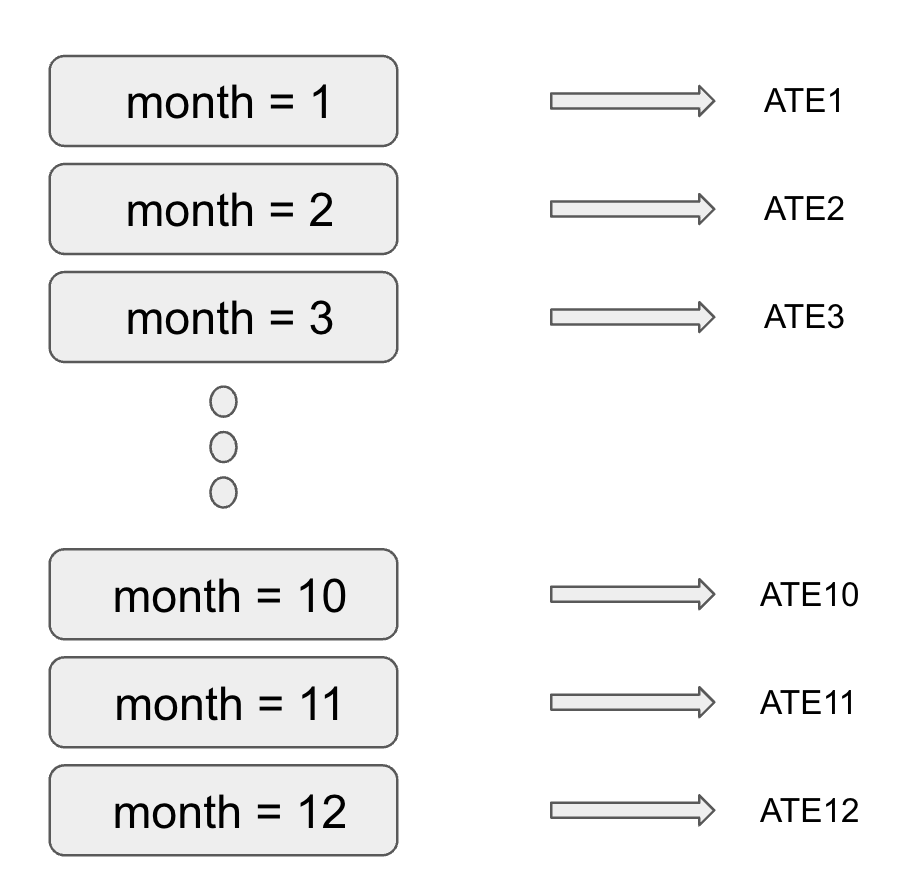

In [ ]:
# 아래 그램처럼 추정하려고 함! (월에 대한 ATE 를 다르게 생성하자. )
from IPython.display import Image
Image('/content/drive/MyDrive/Analysis/20221106 Member Rewards program 효과 추정/img/schema.png')

In [ ]:
interval = estimate.test_stat_significance(confidence_level = 0.95)

In [ ]:
# signup_month 는 시계열적 특성을 나타내므로 모델에 포함하는게 맞을것입니다. 
# 다만 우리의 경우 month 를 고정하고 분석하는것이므로 모델에서는 포함시키지 않겠습니다. 
# Setting the signup month (for ease of analysis)

i = 3
# signup_month = 0,3 인 유저에 대해서 prespend / postspend 를 정의
# 3개월을 기준으로 3개월 이전 spend 평균 / 3개월 이후 spend 평균 2가지를 정의
month_effect = []

class EstimateEffect : 
    """2~12 개월의 ATE 를 추정합니다. 
    """
    def __init__(self):
        self.causal_graph = """digraph {
            treatment[label="Program Signup in 3-month"];
            pre_spends;
            post_spends;
            Z[label = "Unobserved Variable"];
            Z->treatment;
            pre_spends -> post_spends;
            pre_spends -> treatment;
            treatment-> post_spends;
            }"""
        self.month_effect = []
        self.month = []
    def estimate_propensity_for_i_month(self,i):
        print(f"[ ----- {i}th step ----- ]")
        df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
            lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                                'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
        ).reset_index()

        model = dowhy.CausalModel(data=df_i_signupmonth,
                            graph=causal_graph.replace("\n", " "),
                            treatment="treatment",
                            outcome="post_spends")

        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.propensity_score_matching",
                                        target_units="ate")
        self.month.append(i)
        self.month_effect.append(estimate.value)

    def calculation(self) : 
        for i in range(2,12) : 
            self.estimate_propensity_for_i_month(i)
        return pd.DataFrame({"month" : self.month , "month_effect" : self.month_effect})

In [ ]:
model = EstimateEffect()
estimand = model.calculation()

[ ----- 2th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 3th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 4th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 5th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 6th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 7th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 8th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 9th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 10th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ ----- 11th step ----- ]
propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
estimand

,month,month_effect
0,2,100.617670
1,3,99.888399
2,4,99.586447
3,5,99.957261
4,6,100.697317
5,7,99.780140
6,8,100.436483
7,9,99.354124
8,10,102.050084
9,11,99.527487


# 결론 
- 각 month 별로 effect 는 올바르게 100으로 추정하는것을 볼 수 있습니다!